In [54]:
import scanpy as sc
import anndata
#import pl
#import tl
import numpy as np
import time as time

# Load Dataset
filelocation = r"datasets/VBh_converted.h5ad"
adata = anndata.read_h5ad(filelocation)

# subsampling
#sc.pp.subsample(adata, 0.2)

# normalizing
adata.X = np.arcsinh(adata.X / 10)

# calc knn
sc.pp.neighbors(adata, n_neighbors=20)

**HUMAP function**

In [55]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs

import matplotlib.pyplot as plt

def _humap(adata, n_scales: int = 1, factor: float = 0.5, copy: bool = False):
    
    # check if knn graph has been calculated beforehand
    assert 'connectivities' in adata.obsp.keys(), "No knn graph found. Calculate with scanpy.tl.neighbors(...)"
    
    # create list with copy of adata as first element
    scales = list()
    scales.append(adata.copy())
    
    for s in range(n_scales):
        ### getting landmarks
        
        # copy last scale
        speichi = scales[-1].copy()
        
        #sc.pp.neighbors(speichi)
        c = speichi.obsp['connectivities']
        T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))
        D, V = eigs(T.T, which='LM')

        # landmark probabilities
        pi = V[:, 0]
        pi = pi.real
        pi /= pi.sum()

        ### finding inflection point
        
        # TODO find ElbowInflection point and "cut" dataset there
        # find inflection point
        inflectionPoint = findElbowInflection(pi[pi.argsort()][::-1])
        print(f"Inflection point at {inflectionPoint}")
        
        ### subsample data
        
        # indices of landmarks sorted by probability
        lm_ind = pi.argsort()
        
        # speichi = speichi[lm_ind[:int(len(speichi)*factor)]] # version without inflectionPoint
        speichi = speichi[lm_ind[:inflectionPoint]]

        print(f"Calculating scale {s} with {len(speichi)} cells")
        
        # plotting
        plt.plot(pi[pi.argsort()][::-1])
        plt.vlines(inflectionPoint, ymin=0, ymax=max(pi))
        plt.show()
        
        # (re)calculate knn
        sc.pp.neighbors(speichi, n_neighbors=20)
        # calculate umap embedding
        sc.tl.umap(speichi)
        scales.append(speichi)
        
    # removing first element as it is a copy of adata
    scales.pop(0)
    
    # add list of scales to .uns
    adata.uns['HUMAP_scales'] = scales
    return adata if copy else None
    


In [56]:
def findElbowInflection(valArray):
    infPoint = 0
    
    from numpy import diff
    dx = 1
    y = valArray
    dy = diff(y)/dx
    #plt.plot(dy[:int(len(dy)/20)])
    #plt.show()
    
    # version: CUMSUM --> cut where cumsum > 10%
    speichi = 0
    for i in range(len(valArray)):
        speichi += valArray[i]
        if speichi > 0.1:
            infPoint = i
            break
    
    
    #from scipy.signal import savgol_filter
    # yhat = savgol_filter(dy, 201, 3)
    # plt.plot(yhat[:int(len(yhat)/20)])
    # plt.show()
    
    return infPoint
    

Inflection point at 8041
Calculating scale 0 with 8041 cells


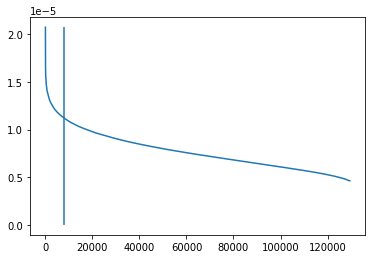

Inflection point at 543
Calculating scale 1 with 543 cells


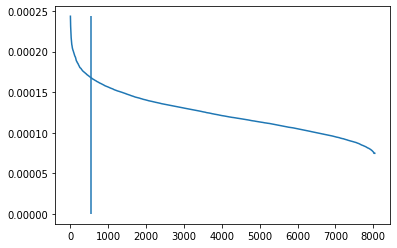

Inflection point at 35
Calculating scale 2 with 35 cells


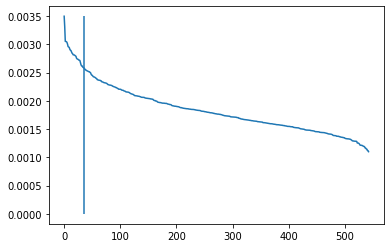

In [57]:
_humap(adata, n_scales = 3, factor = 0.4)

Scale


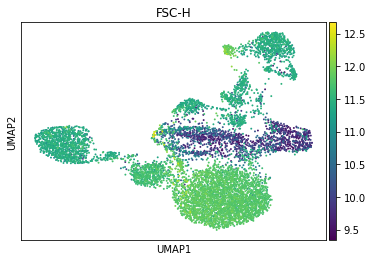

Scale


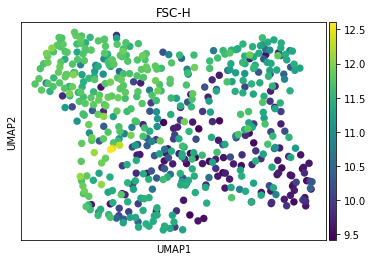

Scale


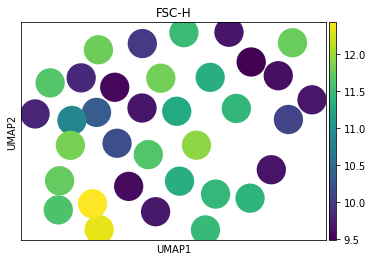

In [58]:
for s in adata.uns['HUMAP_scales']:
    print("Scale")
    sc.pl.umap(s, color=adata.var_names.values[0])

**Calculate Landmarks**

In [ ]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs
# concentrated

c = adata.obsp['connectivities']

T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))

D, V = eigs(T.T, which='LM')

pi = V[:, 0]

pi = pi.real

pi /= pi.sum()

Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])

plt.plot(pi[pi.argsort()][::-1])
plt.show()


In [ ]:
# copy original anndata object
speichi = adata.copy()

percentage = 0.01
# reduce it to certain fraction (landmarks)
speichi = speichi[pi.argsort()[:int(len(adata)*percentage)]]
print(f"Taking {percentage*100}% of all cells as landmarks")
print(f"--> {len(speichi.X)} of originally {len(adata.X)} cells")

# normalizing
speichi.X = np.arcsinh(speichi.X / 10)
# (re)calculate knn
sc.pp.neighbors(speichi, n_neighbors=20)
# calculate umap embedding
sc.tl.umap(speichi)
# plot umap embedding
sc.pl.umap(speichi, color=adata.var_names.values)

In [ ]:
for part in np.linspace(1,0.1,9):
    # copy original anndata object
    speichi = adata.copy()
    # reduce it to certain fraction (landmarks)
    speichi = speichi[pi.argsort()[:int(len(adata)*part)]]
    
    print(f"{len(speichi.X)} of originally {len(adata.X)} cells")
    
    # normalizing
    speichi.X = np.arcsinh(speichi.X / 10)
    # (re)calculate knn
    sc.pp.neighbors(speichi, n_neighbors=20)
    # calculate umap embedding
    sc.tl.umap(speichi)
    # plot umap embedding
    sc.pl.umap(speichi, color=adata.var_names.values[4])